# Analysis of RNA-seq data: read QC and alignment

## Download reference genome 


To download the reference for this lab, we use [ENSEMBL database](https://useast.ensembl.org/Caenorhabditis_elegans/Info/Index). 
In ENSEMBL database, each species may have different releases of genome build. We use `release-111` in this project. 

The genome sequences can be obtained from the link below:
https://ftp.ensembl.org/pub/release-111/fasta/caenorhabditis_elegans/dna/

The genoe anntation file in gtf format can be obtained here: 
https://ftp.ensembl.org/pub/release-111/gtf/caenorhabditis_elegans/


```
%%bash
wget -O Caenorhabditis_elegans.WBcel235.dna.toplevel.fa.gz https://ftp.ensembl.org/pub/release-111/fasta/caenorhabditis_elegans/dna/Caenorhabditis_elegans.WBcel235.dna.toplevel.fa.gz
gunzip Caenorhabditis_elegans.WBcel235.dna.toplevel.fa.gz
```

```
%%bash
## A *fai file will be generated
samtools faidx ref/Caenorhabditis_elegans.WBcel235.dna.toplevel.fa 
```

```
%%bash
wget -O Caenorhabditis_elegans.WBcel235.111.gtf.gz -nv https://ftp.ensembl.org/pub/release-111/gtf/caenorhabditis_elegans/Caenorhabditis_elegans.WBcel235.111.gtf.gz
gunzip Caenorhabditis_elegans.WBcel235.111.gtf.gz
```

In this course, the reference files have been downloaded and stored in shared folder for BIOI611:
/scratch/zt1/project/bioi611/shared/reference/

As you already leart, you can create a symbolic link for you to use in your scratch folder: 



In [2]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
ln -s /scratch/zt1/project/bioi611/shared/reference/ .

### How many chromsomes there are 

In [4]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
grep '>' reference/Caenorhabditis_elegans.WBcel235.dna.toplevel.fa

>I dna:chromosome chromosome:WBcel235:I:1:15072434:1 REF
>II dna:chromosome chromosome:WBcel235:II:1:15279421:1 REF
>III dna:chromosome chromosome:WBcel235:III:1:13783801:1 REF
>IV dna:chromosome chromosome:WBcel235:IV:1:17493829:1 REF
>V dna:chromosome chromosome:WBcel235:V:1:20924180:1 REF
>X dna:chromosome chromosome:WBcel235:X:1:17718942:1 REF
>MtDNA dna:chromosome chromosome:WBcel235:MtDNA:1:13794:1 REF


### How many genes there are 

In [12]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER

grep -v '#' reference/Caenorhabditis_elegans.WBcel235.111.gtf \
       |awk '$3=="gene"' \
       |sed 's/.*gene_biotype "//' \
       |sed 's/";//'|sort |uniq -c \
       | sort -k1,1n

     22 rRNA
    100 antisense_RNA
    129 snRNA
    194 lincRNA
    261 miRNA
    346 snoRNA
    634 tRNA
   2128 pseudogene
   7764 ncRNA
  15363 piRNA
  19985 protein_coding


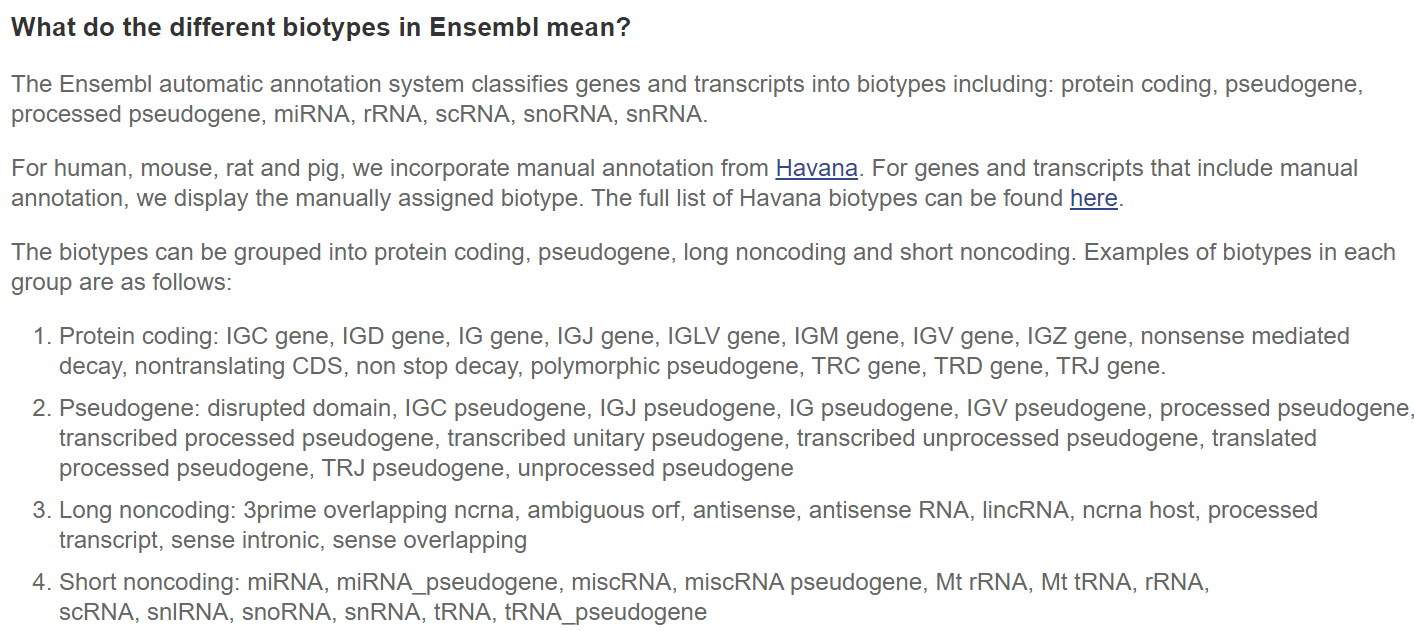
Source: https://useast.ensembl.org/Help/Faq?id=468eudogene


## Download raw fastq files

When scientists publish their results based on NGS data, they are required to deposit the raw data in public database, e.g. NCBI GEO/SRA database. In the manuscript, the accession number is included for the community to search and download the data. Majority of the times, the information will be included in a section called 'Data Availability'. 

Depending on whether GEO or SRA numbers are provided. You can go to either GEO or SRA database:

https://www.ncbi.nlm.nih.gov/sra

https://www.ncbi.nlm.nih.gov/geo/

An alternative way is that you can use third party tool which will help you quick generate the command lines that you can use to download the data. One example is SRA explorer: 

https://sra-explorer.info/

```
%%bash
mkdir -p raw_data/ 
curl -L ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR156/002/SRR15694102/SRR15694102.fastq.gz -o raw_data/N2_day7_rep1.fastq.gz
curl -L ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR156/001/SRR15694101/SRR15694101.fastq.gz -o raw_data/N2_day7_rep2.fastq.gz
curl -L ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR156/000/SRR15694100/SRR15694100.fastq.gz -o raw_data/N2_day7_rep3.fastq.gz
curl -L ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR156/099/SRR15694099/SRR15694099.fastq.gz -o raw_data/N2_day1_rep1.fastq.gz
curl -L ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR156/098/SRR15694098/SRR15694098.fastq.gz -o raw_data/N2_day1_rep2.fastq.gz
curl -L ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR156/097/SRR15694097/SRR15694097.fastq.gz -o raw_data/N2_day1_rep3.fastq.gz
```

## Quality control 

Use FastQC to check the quality of fastq files:

```
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
sbatch ../../shared/scripts/bulkRNA_SE_s1_fastqc.sub
```

Use `trim galore` to remove adaptors, low quality bases and low quality reads. 

```
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
sbatch ../../shared/scripts/bulkRNA_SE_s2_trim_galore.sub
```

The command lines to run `trim_galore` were listed below. In the jobs between, `trim_galore` is executed in container built by `singularity`. 

The input and output folders are all under `/scratch/zt1/project/bioi611/`. When you run trim_galore inside the container, you need to make sure `trim_galore` has access to the input and output files. In the job below, the STAR index files are located in  the shared folder (two levels up). So you need to bind the folder that includes both `$PWD` and the STAR index folder. That's the reason we specify `SIF_BIND="/scratch/zt1/project/bioi611/"`. 


In [12]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
cat ../../shared/scripts/bulkRNA_SE_s2_trim_galore.sub

#!/bin/bash
#SBATCH --partition=standard
#SBATCH -t 40:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=6
#SBATCH --cpus-per-task=12
#SBATCH --job-name=bulkRNA_SE_s2_trim_galore
#SBATCH --mail-type=FAIL,BEGIN,END
#SBATCH --error=%x-%J-%u.err
#SBATCH --output=%x-%J-%u.out

module load singularity
## Binding path and singularity image file 
SIF_BIND="/scratch/zt1/project/bioi611/"
SIF_TRIMGALORE="/scratch/zt1/project/bioi611/shared/software/trimgalore_v0.6.10.sif"

## Paths to working directory and input fastq files
WORKDIR="/scratch/zt1/project/bioi611/user/$USER"
FASTQ_DIR="/scratch/zt1/project/bioi611/shared/raw_data/bulk_RNAseq_SE/"

cd $WORKDIR
date 
singularity exec -B $SIF_BIND $SIF_TRIMGALORE trim_galore --fastqc --cores 4 --output_dir bulk_RNAseq_SE_trim_galore $FASTQ_DIR/N2_day1_rep1.fastq.gz &
singularity exec -B $SIF_BIND $SIF_TRIMGALORE trim_galore --fastqc --cores 4 --output_dir bulk_RNAseq_SE_trim_galore $FASTQ_DIR/N2_day1_rep2.fastq.gz &
singularity exec -B $SIF_BIND $SIF_TRIMGAL

## Read alignment using STAR



#### Generate genome index 

During this step, the reference genome (FASTA file) and annotations (GTF files) are supplied. The genome index are saved to disk and only need to be generated once. 

```
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
sbatch ../../shared/scripts/bulkRNA_s1_star_idx.sub
```

In [ ]:
Here is the content in `bulkRNA_s1_star_idx.sub`: 

In [3]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
cat ../../shared/scripts/bulkRNA_s1_star_idx.sub

#!/bin/bash
#SBATCH --partition=standard
#SBATCH -t 40:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=2
#SBATCH --job-name=bulkRNA_s1_star_idx
#SBATCH --mail-type=FAIL,BEGIN,END
#SBATCH --error=%x-%J-%u.err
#SBATCH --output=%x-%J-%u.out

PATH="/scratch/zt1/project/bioi611/shared/software/STAR_2.7.11b/Linux_x86_64_static/:$PATH"

WORKDIR="/scratch/zt1/project/bioi611/user/$USER"
FASTA="/scratch/zt1/project/bioi611/shared/reference/Caenorhabditis_elegans.WBcel235.dna.toplevel.fa"
GTF="/scratch/zt1/project/bioi611/shared/reference/Caenorhabditis_elegans.WBcel235.111.gtf"

cd $WORKDIR
mkdir STAR_index
STAR --runThreadN 2 --runMode genomeGenerate \
     --genomeDir STAR_index \
     --genomeFastaFiles $FASTA \
     --sjdbGTFfile $GTF


The genome files will be outputted into `STAR_index/`: 

In [4]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
ls STAR_index/

chrLength.txt
chrNameLength.txt
chrName.txt
chrStart.txt
exonGeTrInfo.tab
exonInfo.tab
geneInfo.tab
Genome
genomeParameters.txt
SA
SAindex
sjdbInfo.txt
sjdbList.fromGTF.out.tab
sjdbList.out.tab
transcriptInfo.tab


Important things to keep in mind: 

1. `STAR` is a splicing aware mapper which is required for RNA-seq read alignment

2. Genome index only need to be built one

3. Make sure the reference file and annotation file match each other. 

For a particular species, there might be reference genomes built for different strains/ecotypes. Even for the same strain/ecotype, there could be different versions. 

Human Genome Assemblies, `hg19` and `hg38` are two different versions of the human genome, which is the complete set of DNA in an individual's cells. `Hg19` is the older of the two assemblies and was released in 2002. `Hg38`, also known as `GRCh38`, is the more recent assembly and was released in 2013. It is a more accurate and detailed version of the human genome and includes additional data that was not available when HG19 was released.

After ethe reference genome is built, you can start to align the RNA-seq reads using the command lines below. 

```
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
sbatch ../../shared/scripts/bulkRNA_SE_s3_STAR_align.sub
sbatch ../../shared/scripts/bulkRNA_SE_s4_bam_index.sub
```

In [1]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
cat ../../shared/scripts/bulkRNA_SE_s3_STAR_align.sub

#!/bin/bash
#SBATCH --partition=standard
#SBATCH -t 40:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=6
#SBATCH --cpus-per-task=10
#SBATCH --job-name=bulkRNA_SE_STAR_align
#SBATCH --mail-type=FAIL,BEGIN,END
#SBATCH --error=%x-%J-%u.err
#SBATCH --output=%x-%J-%u.out


PATH="/scratch/zt1/project/bioi611/shared/software/STAR_2.7.11b/Linux_x86_64_static/:$PATH"

INDIR=bulk_RNAseq_SE_trim_galore/
OUTDIR=bulkRNA_SE_STAR_align/

mkdir -p $OUTDIR
STAR --genomeDir STAR_index \
    --outSAMtype BAM SortedByCoordinate \
    --twopassMode Basic \
    --quantMode TranscriptomeSAM GeneCounts \
    --readFilesCommand zcat \
    --outFileNamePrefix $OUTDIR/N2_day1_rep1. \
    --runThreadN 10 \
    --readFilesIn $INDIR/N2_day1_rep1_trimmed.fq.gz > $OUTDIR/N2_day1_rep1.log.txt 2>&1 &
STAR --genomeDir STAR_index \
    --outSAMtype BAM SortedByCoordinate \
    --twopassMode Basic \
    --quantMode TranscriptomeSAM GeneCounts \
    --readFilesCommand zcat \
    --outFileNamePrefix $OUTDIR/N2_day1_rep2. \
    --r

In the `STAR` command lines, the following parameters are used 


* `--genomeDir STAR_index`

`--genomeDir` is required. The name of the parameter is self-explanatory. 

* `--outSAMtype BAM SortedByCoordinate`

This parameter is optional. If not specified, 'SAM' will be used: 
`SAM`: output SAM without sorting

`BAM` format is the binary format for `SAM` file. To understand the details of `BAM/SAM` format, refer to the link [here](https://samtools.github.io/hts-specs/SAMv1.pdf). 


* `--twopassMode Basic`

Wil the parameter above, `STAR` will perform the 1st pass mapping,
then it will automatically extract junctions, insert them into the genome index, and, finally, re-map
all reads in the 2nd mapping pass. This option can be used with annotations, which can be included
either at the run-time, or at the genome generation step


* `--quantMode TranscriptomeSAM GeneCounts`

With parameters above, `STAR` produces both the `Aligned.toTranscriptome.out.bam` and `ReadsPerGene.out.tab` outputs

* `--readFilesCommand zcat`

The parameter specifies the command line (`None`, `zcat` or `bzcat`) to execute for each of the input file

* `--outFileNamePrefix $OUTDIR/N2_day7_rep2.`:  output files name prefix (including full or relative path)

* `--runThreadN 10`: number of threads to run STAR

* `--readFilesIn  $INDIR/N2_day7_rep3_trimmed.fq.gz`: paths to files that contain input read1 (and, if needed, read2)
```

The step below is optional. After alignment, it is good practice to index the sorted BAM file so that downstream tools (such as IGV, featureCounts, or samtools view) can quickly access specific genomic regions.

```
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
sbatch ../../shared/scripts/bulkRNA_SE_s4_bam_index.sub
```

In [8]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
grep 'samtools' ../../shared/scripts/bulkRNA_SE_s4_bam_index.sub

module load samtools
samtools index bulkRNA_SE_STAR_align/N2_day1_rep1.Aligned.sortedByCoord.out.bam &
samtools index bulkRNA_SE_STAR_align/N2_day1_rep2.Aligned.sortedByCoord.out.bam &
samtools index bulkRNA_SE_STAR_align/N2_day1_rep3.Aligned.sortedByCoord.out.bam &
samtools index bulkRNA_SE_STAR_align/N2_day7_rep1.Aligned.sortedByCoord.out.bam &
samtools index bulkRNA_SE_STAR_align/N2_day7_rep2.Aligned.sortedByCoord.out.bam &
samtools index bulkRNA_SE_STAR_align/N2_day7_rep3.Aligned.sortedByCoord.out.bam &


After the job is finished, each `BAM` file will have a `*.bai` file generated: 


In [10]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
ls bulkRNA_SE_STAR_align/*.bai

bulkRNA_SE_STAR_align/N2_day1_rep1.Aligned.sortedByCoord.out.bam.bai
bulkRNA_SE_STAR_align/N2_day1_rep2.Aligned.sortedByCoord.out.bam.bai
bulkRNA_SE_STAR_align/N2_day1_rep3.Aligned.sortedByCoord.out.bam.bai
bulkRNA_SE_STAR_align/N2_day7_rep1.Aligned.sortedByCoord.out.bam.bai
bulkRNA_SE_STAR_align/N2_day7_rep2.Aligned.sortedByCoord.out.bam.bai
bulkRNA_SE_STAR_align/N2_day7_rep3.Aligned.sortedByCoord.out.bam.bai


## Use MultiQC to generate report 

`MultiQC` is a reporting tool that parses results and statistics from bioinformatics tool outputs, such as log files and console outputs. It helps to summarise experiments containing multiple samples and multiple analysis steps. It’s designed to be placed at the end of pipelines or to be run manually when you’ve finished running your tools.

```
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
sbatch ../../shared/scripts/bulkRNA_SE_s5_multiqc.sub
```

In [14]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
grep -v 'SBATCH' ../../shared/scripts/bulkRNA_SE_s5_multiqc.sub

#!/bin/bash

module load singularity
## Paths to working directory and input fastq files
WORKDIR="/scratch/zt1/project/bioi611/user/$USER"

cd $WORKDIR
singularity exec -B $PWD /scratch/zt1/project/bioi611/shared/software/multiqc_v1.25.sif multiqc -f -o bulk_RNAseq_SE_multiqc ./bulk_RNAseq_SE_fastqc/  bulk_RNAseq_SE_trim_galore/ bulkRNA_SE_STAR_align/ 


In the command line above, you will again run `multiqc` in singularity container. This time, `-B $PWD` is used. `$PWD` is a dynamic environmental variable that stores the current working directory in which the input and output of `multiqc` will be store. 

## Use RSeQC to generate QC plots

RSeQC package provides a number of useful modules that can comprehensively evaluate RNA-seq data. 

In this lecture, we are going to use one of the modules `geneBody_coverage.py`. This module is used to check if read coverage is uniform and if there is any 5'/3' bias. This module scales all transcripts to 100 nt and calculates the number of reads covering each nucleotide position. Finally, it generates plots illustrating the coverage profile along the gene body.

```
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
sbatch ../../shared/scripts/bulkRNA_SE_s6_RSeQC_genebody_cov.sub
```

In [2]:
%%bash
cd /scratch/zt1/project/bioi611/user/$USER
cat ../../shared/scripts/bulkRNA_SE_s6_RSeQC_genebody_cov.sub

#!/bin/bash
#SBATCH --partition=standard
#SBATCH -t 40:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --job-name=bulkRNA_SE_s6_RSeQC_genebody_cov.sub
#SBATCH --mail-type=FAIL,BEGIN,END
#SBATCH --error=%x-%J-%u.err
#SBATCH --output=%x-%J-%u.out

module load singularity

## Binding path and singularity image file
SIF_BIND="/scratch/zt1/project/bioi611/"
SIF_TRIMGALORE="/scratch/zt1/project/bioi611/shared/software/rseqc_v5.0.3.sif"
SIF_BEDOPS="/scratch/zt1/project/bioi611/shared/software/bedops_v2.4.39.sif"
## Paths to working directory and input fastq files
WORKDIR="/scratch/zt1/project/bioi611/user/$USER"

cd $WORKDIR


mkdir -p bulk_RNAseq_SE_RSeQC/
singularity exec -B $SIF_BIND $SIF_TRIMGALORE geneBody_coverage.py -r /scratch/zt1/project/bioi611/shared/reference/Caenorhabditis_elegans.WBcel235.111.bed -i bulkRNA_SE_STAR_align/N2_day1_rep1.Aligned.sortedByCoord.out.bam,bulkRNA_SE_STAR_align/N2_day7_rep1.Aligned.sortedByCoord.out.bam -o bulk_RNAseq_SE_RSeQC

After the job above is completed, one of the output file is a PDF file. As you can see, in the two samples checked, the coverage over the gene body is quite uniform. 

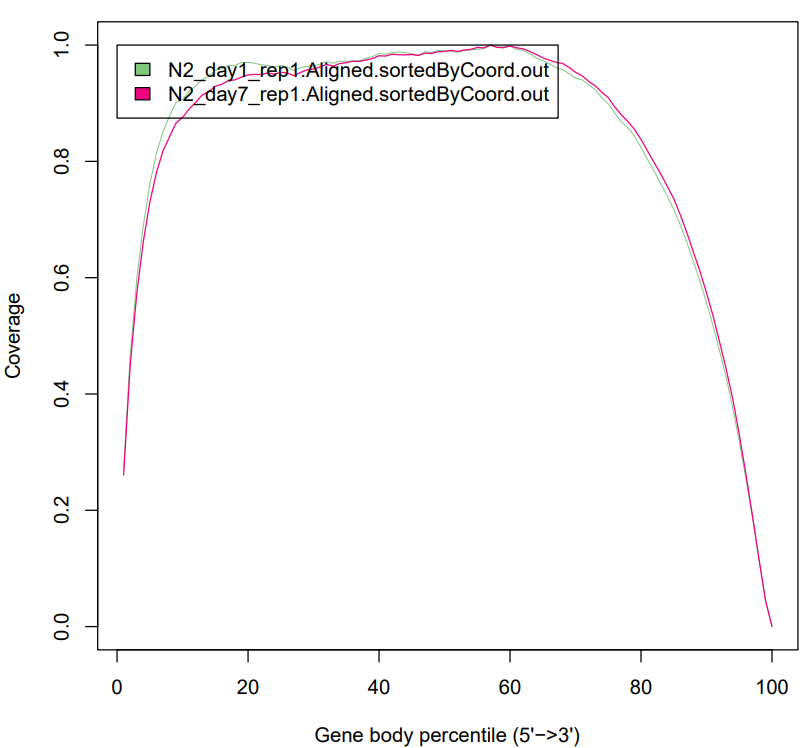

`Caenorhabditis_elegans.WBcel235.111.bed` is used as one of the input for `geneBody_coverage.py` in RSeQC. To understand the bed file format, please refer to the link below: 

https://genome.ucsc.edu/FAQ/FAQformat.html#format1

The bed file can be genreated using GFF3 file. GFF3 format is a similar format as GTF. To generate bed file from GFF3 file, you can use the command line below:

```
wget https://ftp.ensembl.org/pub/release-111/gff3/caenorhabditis_elegans/Caenorhabditis_elegans.WBcel235.111.gff3.gz
export PATH="/scratch/zt1/project/bioi611/shared/software:$PATH"
gff3ToGenePred  Caenorhabditis_elegans.WBcel235.111.gff3  Caenorhabditis_elegans.WBcel235.111.phred
genePredToBed  Caenorhabditis_elegans.WBcel235.111.phred Caenorhabditis_elegans.WBcel235.111.bed
```

## Advanced topcis

### Bind paths and mounts in sigularity

Singularity allows you to map directories on your host system to directories within your container using bind mounts. This allows you to read and write data on the host system with ease.

The system administrator has the ability to define what bind paths will be included automatically inside each container. Some bind paths are automatically derived (e.g. a user’s home directory) and some are statically defined (e.g. bind paths in the Singularity configuration file). In the default configuration, the directories `$HOME`, `/tmp`, `/proc`, `/sys`, `/dev`, and `$PWD` are among the system-defined bind paths.

On UMD HPC, `$PWD` is not defined. So you have to mount the path via the command line parameter `-B/--bind`. 

You can go into the singlarity container just as you are working in a linux system. 


```
%%bash
module load singularity
SIF_TRIMGALORE="/scratch/zt1/project/bioi611/shared/software/trimgalore_v0.6.10.sif"
singularity exec $SIF_TRIMGALORE /bin/bash
```
You will be in the container after you run the command lines above. You can then run the Linux commands you leart from previous classes. To exit the container, simply press `ctrl+d` on your keyborad. 

Running the commands below, you run `ls $FASTQ_DIR` inside the container to list the fastq files. 

In [15]:
%%bash
module load singularity
## Binding path and singularity image file 
SIF_BIND="/scratch/zt1/project/bioi611/"
SIF_TRIMGALORE="/scratch/zt1/project/bioi611/shared/software/trimgalore_v0.6.10.sif"
## Paths to working directory and input fastq files
WORKDIR="/scratch/zt1/project/bioi611/user/$USER"
FASTQ_DIR="/scratch/zt1/project/bioi611/shared/raw_data/bulk_RNAseq_SE/"
cd $WORKDIR 
singularity exec -B $SIF_BIND $SIF_TRIMGALORE ls $FASTQ_DIR

N2_day1_rep1.fastq.gz
N2_day1_rep2.fastq.gz
N2_day1_rep3.fastq.gz
N2_day7_rep1.fastq.gz
N2_day7_rep2.fastq.gz
N2_day7_rep3.fastq.gz


Running the commands below, the command lines will fail because `$WORKDIR` is not mounted. 

In [20]:
%%bash
module load singularity
## Binding path and singularity image file 
SIF_BIND="/scratch/zt1/project/bioi611/"
SIF_TRIMGALORE="/scratch/zt1/project/bioi611/shared/software/trimgalore_v0.6.10.sif"
## Paths to working directory and input fastq files
WORKDIR="/scratch/zt1/project/bioi611/user/$USER"
FASTQ_DIR="/scratch/zt1/project/bioi611/shared/raw_data/bulk_RNAseq_SE/"
cd $WORKDIR 
singularity exec $SIF_TRIMGALORE ls $WORKDIR

ls: /scratch/zt1/project/bioi611/user/xie186: No such file or directory


CalledProcessError: Command 'b'module load singularity\n## Binding path and singularity image file \nSIF_BIND="/scratch/zt1/project/bioi611/"\nSIF_TRIMGALORE="/scratch/zt1/project/bioi611/shared/software/trimgalore_v0.6.10.sif"\n## Paths to working directory and input fastq files\nWORKDIR="/scratch/zt1/project/bioi611/user/$USER"\nFASTQ_DIR="/scratch/zt1/project/bioi611/shared/raw_data/bulk_RNAseq_SE/"\ncd $WORKDIR \nsingularity exec $SIF_TRIMGALORE ls $WORKDIR\n'' returned non-zero exit status 1.

### Use `samtools` to display the content of `BAM` files

`Samtools` is a powerful tool that can be used to display and manipulate `SAM/BAM` files. The command lines below shows you how to use `samtools view` to display the content: the headers and the alignments. 

In [24]:
%%bash
module load samtools
WORKDIR="/scratch/zt1/project/bioi611/user/$USER"
samtools view -H $WORKDIR/bulkRNA_SE_STAR_align/N2_day1_rep1.Aligned.sortedByCoord.out.bam

@HD	VN:1.4	SO:coordinate
@SQ	SN:I	LN:15072434
@SQ	SN:II	LN:15279421
@SQ	SN:III	LN:13783801
@SQ	SN:IV	LN:17493829
@SQ	SN:V	LN:20924180
@SQ	SN:X	LN:17718942
@SQ	SN:MtDNA	LN:13794
@PG	ID:STAR	PN:STAR	VN:2.7.11b	CL:STAR   --runThreadN 10   --genomeDir STAR_index   --readFilesIn bulk_RNAseq_SE_trim_galore//N2_day1_rep1_trimmed.fq.gz      --readFilesCommand zcat      --outFileNamePrefix bulkRNA_SE_STAR_align//N2_day1_rep1.   --outSAMtype BAM   SortedByCoordinate      --quantMode TranscriptomeSAM   GeneCounts      --twopassMode Basic
@PG	ID:samtools	PN:samtools	PP:STAR	VN:1.17	CL:samtools view -H /scratch/zt1/project/bioi611/user/xie186/bulkRNA_SE_STAR_align/N2_day1_rep1.Aligned.sortedByCoord.out.bam
@CO	user command line: STAR --genomeDir STAR_index --outSAMtype BAM SortedByCoordinate --twopassMode Basic --quantMode TranscriptomeSAM GeneCounts --readFilesCommand zcat --outFileNamePrefix bulkRNA_SE_STAR_align//N2_day1_rep1. --runThreadN 10 --readFilesIn bulk_RNAseq_SE_trim_galore//N2_day1_rep

In [28]:
%%bash
module load samtools
WORKDIR="/scratch/zt1/project/bioi611/user/$USER"
samtools view -h $WORKDIR/bulkRNA_SE_STAR_align/N2_day1_rep1.Aligned.sortedByCoord.out.bam |head -14

@HD	VN:1.4	SO:coordinate
@SQ	SN:I	LN:15072434
@SQ	SN:II	LN:15279421
@SQ	SN:III	LN:13783801
@SQ	SN:IV	LN:17493829
@SQ	SN:V	LN:20924180
@SQ	SN:X	LN:17718942
@SQ	SN:MtDNA	LN:13794
@PG	ID:STAR	PN:STAR	VN:2.7.11b	CL:STAR   --runThreadN 10   --genomeDir STAR_index   --readFilesIn bulk_RNAseq_SE_trim_galore//N2_day1_rep1_trimmed.fq.gz      --readFilesCommand zcat      --outFileNamePrefix bulkRNA_SE_STAR_align//N2_day1_rep1.   --outSAMtype BAM   SortedByCoordinate      --quantMode TranscriptomeSAM   GeneCounts      --twopassMode Basic
@PG	ID:samtools	PN:samtools	PP:STAR	VN:1.17	CL:samtools view -h /scratch/zt1/project/bioi611/user/xie186/bulkRNA_SE_STAR_align/N2_day1_rep1.Aligned.sortedByCoord.out.bam
@CO	user command line: STAR --genomeDir STAR_index --outSAMtype BAM SortedByCoordinate --twopassMode Basic --quantMode TranscriptomeSAM GeneCounts --readFilesCommand zcat --outFileNamePrefix bulkRNA_SE_STAR_align//N2_day1_rep1. --runThreadN 10 --readFilesIn bulk_RNAseq_SE_trim_galore//N2_day1_rep

In [30]:
%%bash
module load samtools
WORKDIR="/scratch/zt1/project/bioi611/user/$USER"
samtools view $WORKDIR/bulkRNA_SE_STAR_align/N2_day1_rep1.Aligned.sortedByCoord.out.bam |head -4

SRR15694099.8922190	256	I	2366	0	96M	*	0	0	TGAAAATTTTGTGATTTTCGTAAATTTATTCCTATTTATTAATAAAAACAAAAACAATTCCATTAAATATCCCATTTTCAGCGCAAAATCGACTGG	CCCFFFFFHHHHHJJJJJJJIJJJJJJJJJJJJJJJIJJJJJJJIJJIIIIJJJJJJJJJJJJJJJJJJJIJJJJIIJJHHGHFFDDDDCDDDDD@	NH:i:8	HI:i:8	AS:i:94	nM:i:0
SRR15694099.16768635	16	I	2481	1	95M	*	0	0	GAGATAGAACGGATCAACAAGATTATTATTATATCATTAATAATATTTATCAATTTTCTTCTGAGAGTCTCATTGAGACTCTTATTTACGCCAAG	;>@EEAB@;B;EAA6.=7==>GEAGAGEGHF>F=FCHEFDBGBFD<D9GBBBBBB;;D?BF@DFEGDHFEIIIHEGIIFFDHFBFDD<DDDA@@@	NH:i:4	HI:i:1	AS:i:93	nM:i:0
SRR15694099.10859917	0	I	2602	255	71M	*	0	0	ATTTTTGAAAAAAAAATAATTAAAAAAACACATTTTTTGGAAAAAAAAATAAATAAAAAAAATTGTCCTCG	?@@DDEDB?HHBDHGIIIGIIGCBBGEHAF?GIHIIIGGFBCCEBB@BBBCCCEECCCCBBBBCCC@CCC@	NH:i:1	HI:i:1	AS:i:69	nM:i:0
SRR15694099.30104406	16	I	2611	255	40M1I55M	*	0	0	AAAAAAATAATTAAAAAAACACATTTTTTGGAAAAAAAAAATAAATAAAAAAAATTGTCCTCGAGGATCCTCCGGAGCGCGTCGAATCAATGTTTC	BBDDAB>>A>48BBDCCC@4((<5AA>4(43BDDDDDDACC@CCA?DBACDB?BHE=;EA;<EFB=81@F:BGHGBBA8BFBGBHHHBFFEDD?@@	NH:i:1	HI